`This report is part of the interview process at Oslo Metropolitan University in Norway`

In this report, we will use machine learning models for classification lower back pain. The task is to classify whether each data sample is normal or abnormal based of a set of features. The number of features in the dataset is 12. The dataset is taken from the website [Kaggle website](https://www.kaggle.com/sammy123/lower-back-pain-symptoms-dataset)). The dataset contains 310 data samples.

In this report, we will go through

- Using Machine Learning models
  - Logistic Regression.
  - Decision Trees.
  - Random Forest.
  - Support Vector Machine (SVM)
  - XGBoost Classifier
  - Artifical Neural Networks (ANN)
- Explaining the predictions
  - SHAP.
  - InterpretML
- Hyperparameter Optimization 
  - Grid Search.

## 1. Import Packages

We'll first import all the common packages that we need for this assignment. 

- `shap` is a library that explains predictions made by machine learning models.
- `interpret` is a library that explains predictions made by machine learning models.
- `lime` is a library that explains predictions made by machine learning models.
- `pytorch` is a Framework for building neural networks architectures.
- `sklearn` is machine learning library 
- `xgboost` is machine learning library 
- `numpy` is a Python scientific computing package.
- `math` is a python module for mathimatical functions
- `scipy` is a Python scientific computing package.
- `pandas` is used for data wrangling
- `seaborn` is a plotting and visualizing library
- `matplotlib` is a plotting library.

In [140]:
import shap
from interpret import show
from interpret.blackbox import LimeTabular
from interpret.glassbox import ClassificationTree
from interpret.glassbox import LogisticRegression as LogReg

import torch
from torch import nn
import torch.optim as optim

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import pandas as pd
import numpy as np
import math
from scipy.stats import zscore

import xgboost as xgb 

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score 
from sklearn.metrics import recall_score, accuracy_score, precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from IPython.display import clear_output

## 2. Reading Dataset

We use pandas library to read csv file. The columns names are stored in the last column in the dataframe which is named "Unnamed: 13". The dataset contains 12 features shown in columns and label column. 

The features are: 
- `pelvic_incidence`
- `pelvic_tilt`
- `lumbar_lordosis_angle`
- `sacral_slope`
- `pelvic_radius`
- `degree_spondylolisthesis`
- `Direct_tilt`
- `scoliosis_slope`
- `cervical_tilt`
- `sacrum_angle`
- `pelvic_slope`
- `thoracic_slope`

In [141]:
df = pd.read_csv('./data/Dataset_spine.csv')

# get column names for better visualization
column_names = list(df['Unnamed: 13'])[5:17]
column_names = [col.split("=")[1].strip().replace(
    '(numeric)', '').strip() for col in column_names]
column_names.append('labels')

## 3. Exploratory Data Analysis

We notice from the statistics of the data that the maximum value of the feature degree_spondylolisthesis is 418.5 which is extremely far from the 75 percentile (41.28). This simply means that this data point could be an extreme outlier and it could be an error in measurement.  

In [142]:
labels = df['Class_att']
y = [1 if label == 'Abnormal' else 0 for label in labels]
df['Class_att'] = y
df = df.drop(['Unnamed: 13'], axis=1)
df.columns = column_names
df.describe()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,labels
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694,0.472979,21.321526,13.064511,11.933317,-14.053139,25.645981,0.677419
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027,0.285787,8.639423,3.399713,2.893265,12.225582,10.450558,0.468220
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179,0.003220,7.027000,7.037800,7.030600,-35.287375,7.007900,0.000000
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727,0.224367,13.054400,10.417800,9.541140,-24.289522,17.189075,0.000000
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934,0.475989,21.907150,12.938450,11.953835,-14.622856,24.931950,1.000000
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352,0.704846,28.954075,15.889525,14.371810,-3.497094,33.979600,1.000000
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082,0.998827,36.743900,19.324000,16.821080,6.972071,44.341200,1.000000


We visualize the data using boxplot. We notice there is one extreme outlier in the degree_spondylolisthesis feature. So, we decided to remove this outlier. This outlier can be removed manually or using any outlier detection. This extreme outlier seems to be error in measurements and can be corrected by replacing it with average of the feature.

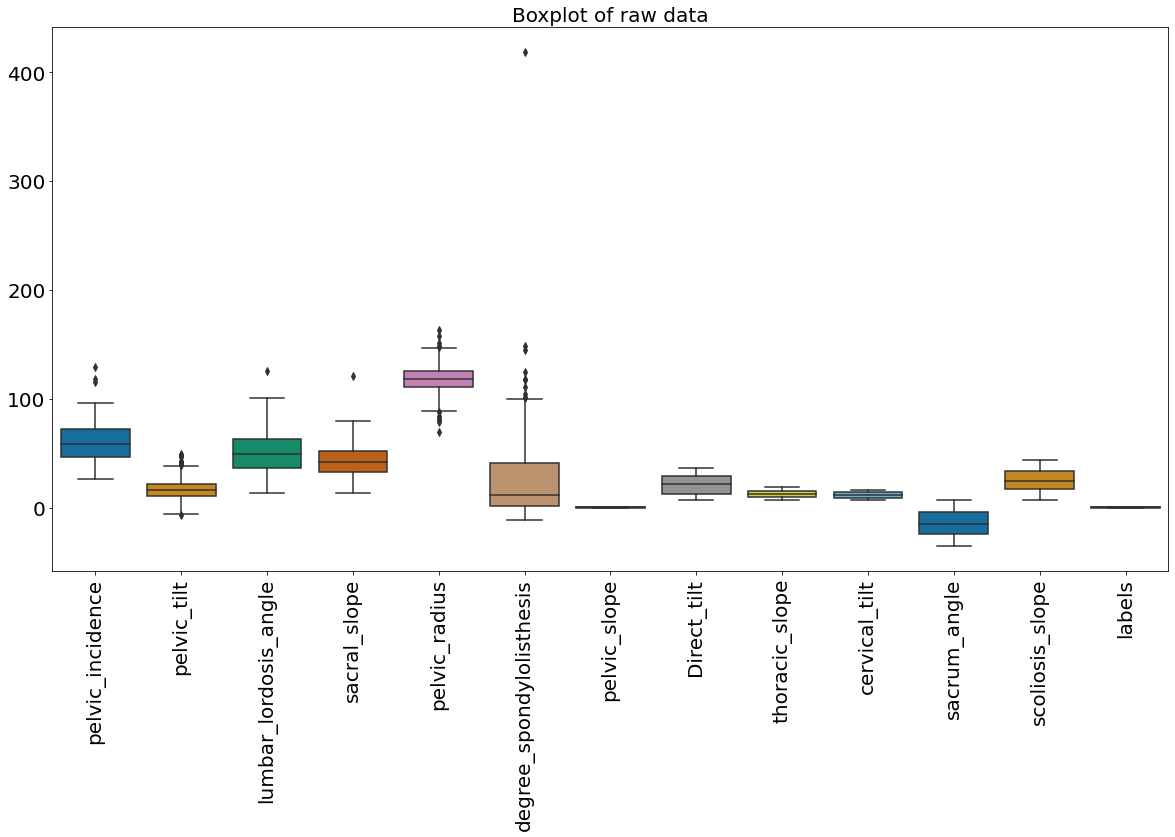

In [143]:
plt.figure(figsize=(20, 10))
plt.title('Boxplot of raw data', fontsize=20)
plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=20)
sns.boxplot(data=df, palette="colorblind")
plt.show()

In these methods, We used z-score to detect outliers.

In [144]:
def z_score(df):
    """
    Application of zscore filtering on raw data to remove outliers
    """
    clean_df = df
    for col in df.columns:
        z_scores = zscore(clean_df[[col]])
        abs_z_scores = np.abs(z_scores)
        filtered_entries = (abs_z_scores < 10).all(axis=1)
        clean_df = clean_df[filtered_entries]
    return clean_df

df = z_score(df)

The next cell shows the histogram of all the observations (after removing the one extreme data sample). Some features show normal distribution such as pelvic tilt, pelvic_radius and sacral slope. There are still some noticable outliers in pelvic incidence and kumbar lordosis angle. We decided NOT to remove these outliers because this could be losing valuable data samples given the samell size of the entire dataset.   

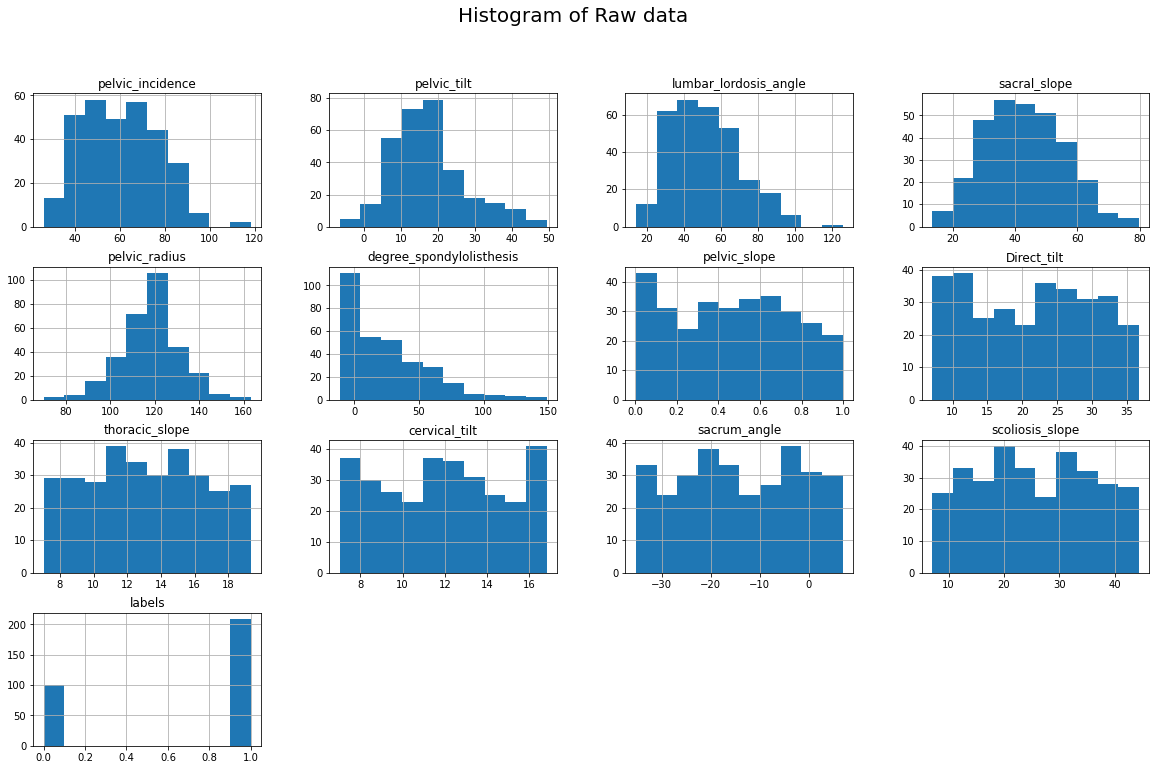

In [145]:
#Histogram of Raw Data
df.hist(figsize=(20, 12))
plt.suptitle('Histogram of Raw data', fontsize=20)
plt.show()

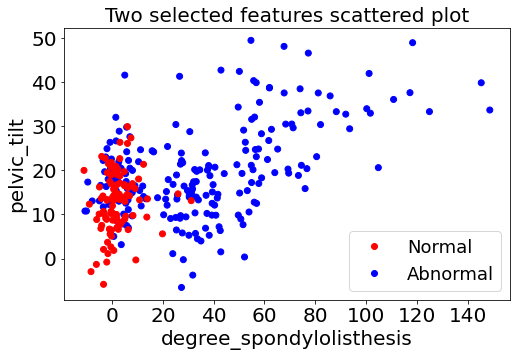

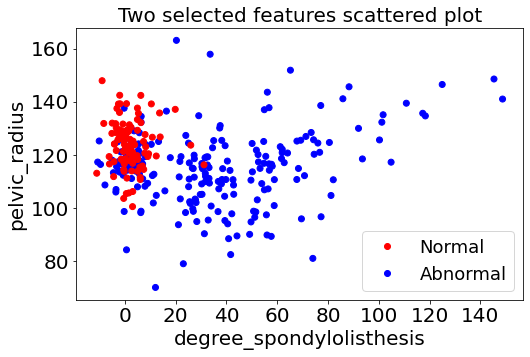

In [146]:
def plot_features(f1, f2):
    colors = ListedColormap(['r','b'])
    classes = ['Normal', 'Abnormal']
    fig = plt.figure(figsize=(8,5))
    label = df.labels
    plt.title('Two selected features scattered plot', fontsize=20)
    scatter = plt.scatter(f1, f2, c=label, cmap=colors)
    plt.legend(handles=scatter.legend_elements()[0], labels=classes, fontsize=18)
    plt.xlabel(f1.name, fontsize=20)
    plt.ylabel(f2.name, fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()
    
plot_features(df.degree_spondylolisthesis, df.pelvic_tilt)
plot_features(df.degree_spondylolisthesis, df.pelvic_radius)

Then, we split the data into train and test subsets. The test data size is 33% of the entire data. We standardize the train data here by each by reducing the mean of the data samples from each data sample and subdivide each data sample by the standard deviation. 

In [147]:
# split the data into and test subsets 
X = df.loc[:, df.columns != 'labels']
y = df.loc[:, df.columns == 'labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=404, stratify=y)
y_train = np.array(y_train).ravel()

# standardize the train and test data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# convert the arrays into dataframe
X_train = pd.DataFrame(X_train)
X_train.columns = column_names[:-1]
X_test = pd.DataFrame(X_test)
X_test.columns = column_names[:-1]

Then we try to extract principle componants from the data. We noticed that 10 PCA would explain the 12 features. however, we end up using the original features in order to be able of using the interpretation of features later using shap or lime.

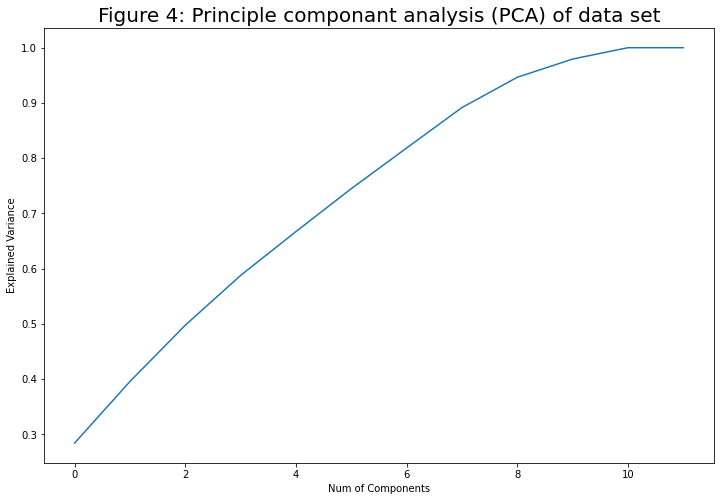

In [72]:
from sklearn.decomposition import PCA
pca = PCA(n_components=12)
pca.fit(X_train)
cum_var = pca.explained_variance_ratio_.cumsum()

plt.figure(figsize=(12,8))
plt.plot(cum_var)
plt.xlabel('Num of Components')
plt.ylabel('Explained Variance')
plt.title('Figure 4: Principle componant analysis (PCA) of data set', fontsize=20)
plt.show()

## 4. Models

## Logistic Regression

Logistic regression is based on the logistic function or sigmoid function $f(z) = \frac{1}{1+e^{-z}}$. This function leads to squeezing the values from (-infinity, +infinity) to values in between (0, 1) which represents probability. The earlier mentioned $z$ is a combination of the features multiplied by weights.$z=b1*x1+b2*x2+...+a$ where $b1, b2..., a$ are coefficients and $x1, x2..$ are the feature values. The weights can be learned using learning algorithm (Gradient algorithm such as LBFGS) to optimize the loss function (Log Loss). 

In [8]:
logReg = LogisticRegression(random_state=404, solver='lbfgs')
logReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=404, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

The recorded evaluation matrics are **accuracy**, **f1**, **precision** and **recall** to quantify the amount of true positive and true negatives in the predictions.

$P = \frac {TP}{TP+FP} $

$R = \frac {TP}{TP+FN} $

$Acc = \frac {TP+TN}{TP+TN+FP+FN} $

$f1 = \frac {2P*R}{P+R} $


There are three types of evaluation metrics: **Macro**, **Micro** and **Weighted**. **Weighted** average F1, Precision and Recall scores can also be measured as arithmetic mean of all the measured F1, Precision and Recall scores for each class weighted by the number of support of that class. **Micro** averaged F1, Precision and Recall are calculated using the total TP by looking at all the samples together. For example, **micro** Precision counts the total number of TP and FP in the entire data before calculating the measure. For **macro** Precision, TP and FP are counted and the measure is calculated for each class before taking arithmetic mean. If the data is balanced, macro and micro measures will show identical results.

In [9]:
y_hat = logReg.predict(X_test)
print('Accuracy: ', logReg.score(X_test, y_test))
print('Macro F1 Score: ', f1_score(y_test,y_hat, average='macro'))
print('Macro Precision Score: ', precision_score(y_test,y_hat, average='macro'))
print('Macro Recall Score: ', recall_score(y_test,y_hat, average='macro'))

Accuracy:  0.8627450980392157
Macro F1 Score:  0.840625
Macro Precision Score:  0.8468877782825988
Macro Recall Score:  0.8353096179183135


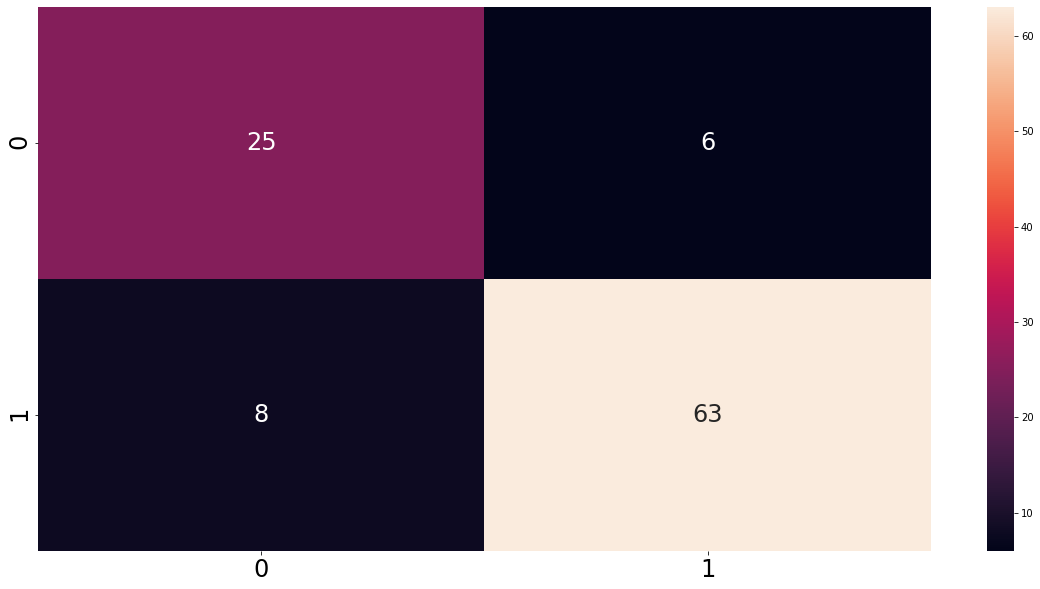

In [11]:
def conf_plot(y_hat, y_test):
    plt.figure(figsize=(20, 10))
    sns.heatmap(confusion_matrix(y_hat, y_test), annot=True, annot_kws={"size":24})
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.show()
    
conf_plot(y_hat, y_test)

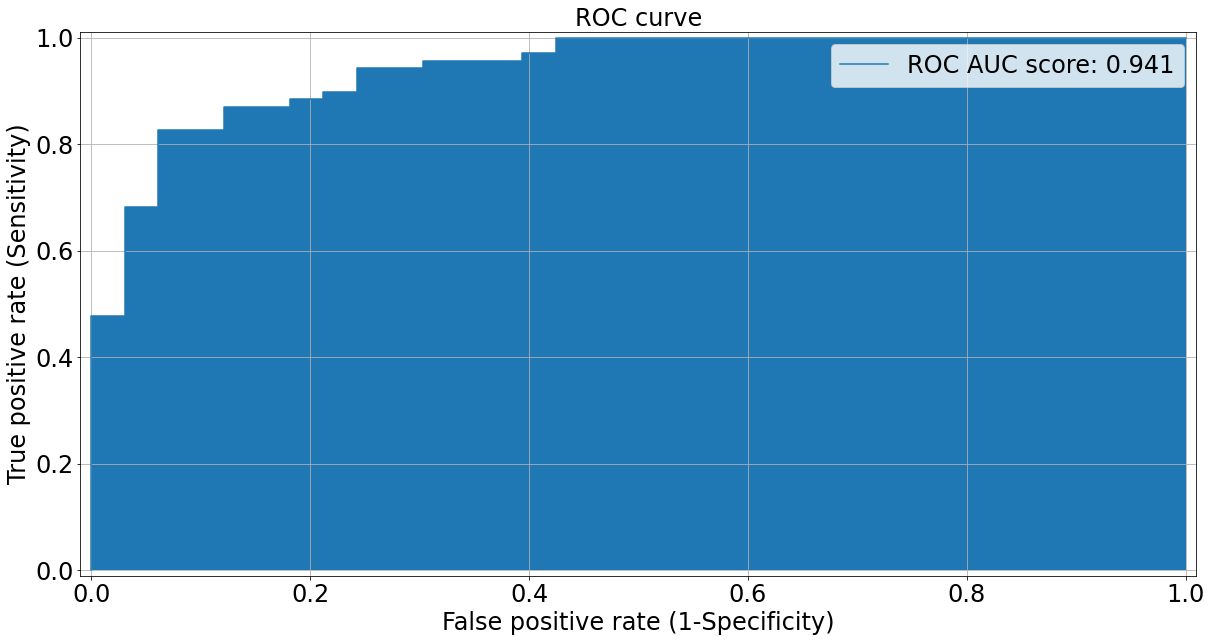

In [12]:
def roc_curve_plot(model, x, y):
    plt.figure(figsize=(20, 10))
    
    y_pred=model.predict_proba(x)[:,:]
    auc_score = roc_auc_score(y,y_pred[:,1])    

    fpr, tpr, thresholds = roc_curve(y, y_pred[:, 1])
    plt.plot(fpr,tpr, label="ROC AUC score: "+str(auc_score)[:5])
    plt.fill_between(fpr,tpr)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.title('ROC curve', fontsize=24)
    plt.xlabel('False positive rate (1-Specificity)', fontsize=24)
    plt.ylabel('True positive rate (Sensitivity)', fontsize=24)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.legend(fontsize=24)
    plt.grid(True)
    plt.show()
    
roc_curve_plot(logReg, X_test, y_test)

In [13]:
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.81      0.76      0.78        33
           1       0.89      0.91      0.90        69

    accuracy                           0.86       102
   macro avg       0.85      0.84      0.84       102
weighted avg       0.86      0.86      0.86       102



The next is using Shaply values to quantify the contributions of each features into making the predictions by the blackbox model. The main intuition is based on removing one feature (also for each subset to measure the intercation between features) at a time and check how the performance would change. Shaply is usually local interpretation technique but it also can be used for global interperation using aggregations.

In [14]:
explainer = shap.LinearExplainer(logReg, X_train)
shap_values = explainer(X_test)

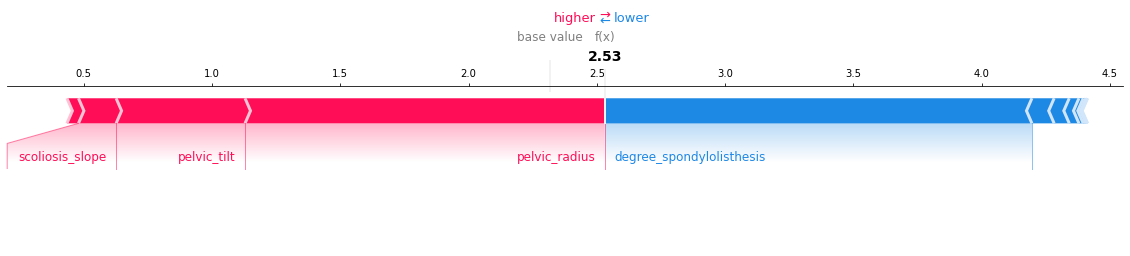

In [15]:
shap.force_plot(shap_values[1, :].base_values, shap_values[1, :].values, feature_names=column_names[:-1], matplotlib=True)

- The next waterfall plot are displays explanations for individual predictions. 

- The x axis of a waterfall is the expected value the model output. 

- Each row shows how the positive (red) or negative (blue) contribution of each feature moves the value from the expected model output over the whole dataset to the model output for this prediction.

- the grey number to the left-most is the value of the feature for this data sample

We notice that degree_spondylolisthesis and pelvic_radius are the most important here in this example. We notice here that shapley values of shape (102, 12, 2). 102 is number of samples in test set, 12 is number of features and 2 is number of classes.
 

In [60]:
shap_values.values.shape

(102, 12, 2)

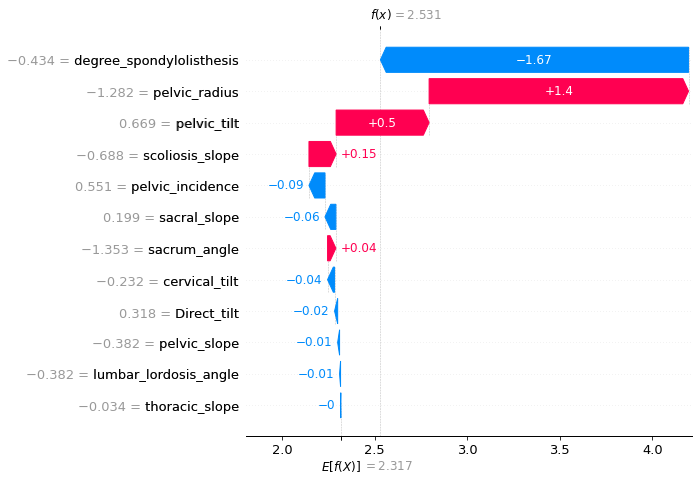

In [16]:
shap.plots.waterfall(shap_values[1], max_display=12)

- The beeswarm plot displays a summary of how the features in a dataset impact the model’s output. 

- Each sample is represented by a single dot on each feature fow. 

- The x position of the dot is determined by the SHAP value of that feature, and dots “pile up” row to show density. 

- Color is used to display the original value of a feature. 

- In the plot below we can see that degree_spondyloisthesis is the most important feature on average.

This graph is interesting as it show relationship between shap values and feature values. This means from this graph, in specific,  that higher values are lower values are clusterted in the classifications. Low values of degree_spondyloisthesis is connected to normal class and higher degree_spondyloisthesis is in abonraml class.

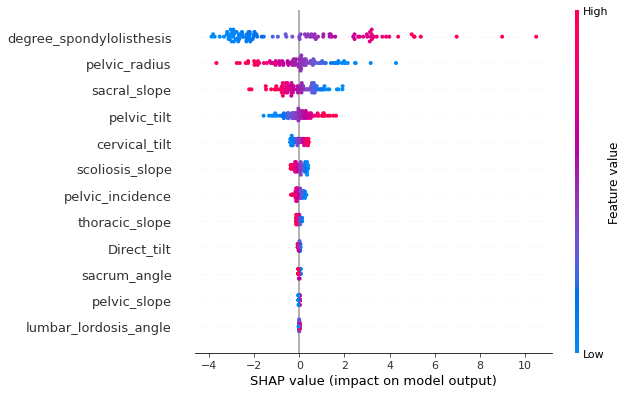

In [18]:
shap.plots.beeswarm(shap_values, max_display=12)

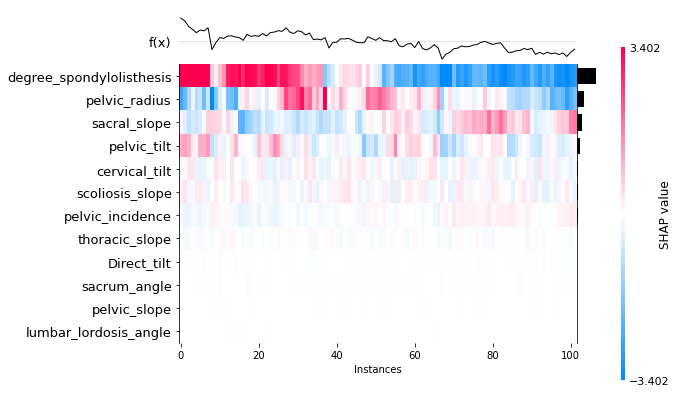

In [17]:
shap.plots.heatmap(shap_values, max_display=12)

In [18]:
#The following graphic unfortuantely won't show untill the code be run again
lime = LimeTabular(predict_fn=logReg.predict_proba, data=X_train, random_state=404)
lime_local = lime.explain_local(X_test[:10], y_test[:10])
show(lime_local)


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`

The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`

The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`


<!-- http://127.0.0.1:7001/140230794151312/ -->

## Decision Tree

The decision tree simply contains two types of nodes (decision nodes and leaf nodes). The decision node is a question to split the data into two parts. The question is reptaed for the child nodes untill we have a child that is pure. In practice, we will not have a pure child. The questions are learned using "entropy" which simply quantify the purity of the child nodes. The entropy is given as $\sum -p_i log(p_i)$ where $p_i$ is the probability of the class $i$. If the child node is an equal mix of the two classes (Decision tree is not working efficiently). the entropy will equal to $1$ as $-p_i log p_i = (-0.5 * log(0.5)) + (-0.5 * log(0.5)) = 1$. This means the entropy is high. This means we want to maximize the purity of each child node. Information gain is how much the purity changed after introducing the question which simply equals the entropy of child node minus the entropy of parent node. We want to maximize the information gain.  

In [19]:
dt = DecisionTreeClassifier(max_depth=100, random_state=10)
print(dt)

from sklearn.model_selection import GridSearchCV

parameteres = {'max_depth': np.arange(1,100,10),
               'criterion': ['gini', 'entropy']}

grid_dt = GridSearchCV(dt, param_grid=parameteres, cv=StratifiedKFold(n_splits=5), iid = 'True')

grid_dt.fit(X_train, y_train)
print('Best Score: ', grid_dt.best_score_)
print('Best Params: ', grid_dt.best_params_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=100,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=10, splitter='best')
Best Score:  0.782608695652174
Best Params:  {'criterion': 'entropy', 'max_depth': 11}


In [20]:
dt = DecisionTreeClassifier(**grid_dt.best_params_)
dt.fit(X_train, y_train)
y_hat = dt.predict(X_test)
print('Accuracy: ', dt.score(X_test, y_test))
print('Macro F1 Score: ', f1_score(y_test,y_hat, average='macro'))
print('Macro Precision Score: ', precision_score(y_test,y_hat, average='macro'))
print('Macro Recall Score: ', recall_score(y_test,y_hat, average='macro'))

Accuracy:  0.7745098039215687
Macro F1 Score:  0.7444166031158079
Macro Precision Score:  0.7426470588235294
Macro Recall Score:  0.7463768115942029


In [21]:
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.65      0.67      0.66        33
           1       0.84      0.83      0.83        69

    accuracy                           0.77       102
   macro avg       0.74      0.75      0.74       102
weighted avg       0.78      0.77      0.78       102



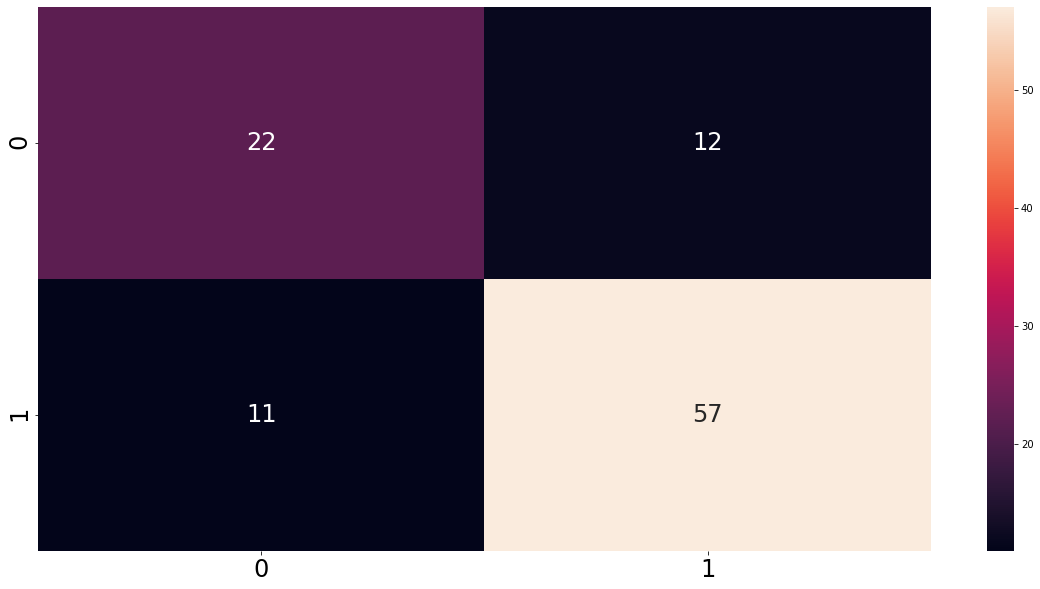

In [22]:
conf_plot(y_hat, y_test)

In [23]:
explainer = shap.TreeExplainer(dt, X_train)
shap_values = explainer(X_test)

Notice the base value is around 0.33 which actually make sense as the number of 'abnormal' classes are almost 2/3 of the entire dataset, So the average of labels is 0.33. We notice that degree_spondyloisthesis, sacral_slope, cervical_tilt are the features that push the model to make this prediction as 'abnormal'  

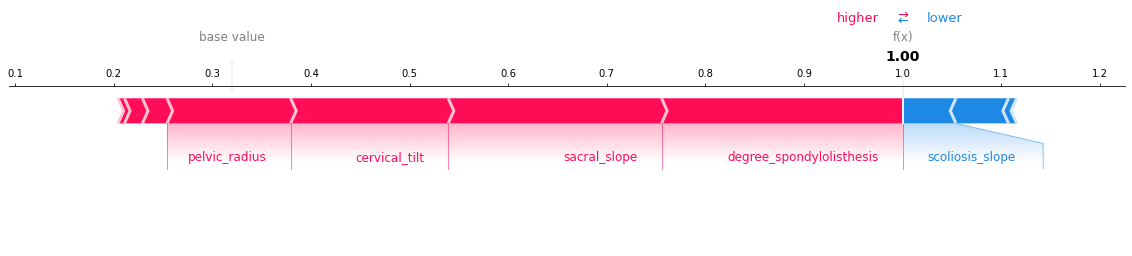

In [24]:
shap.force_plot(shap_values[1, :].base_values[0], shap_values[1, :].values[:, 0], feature_names=column_names[:-1], matplotlib=True)

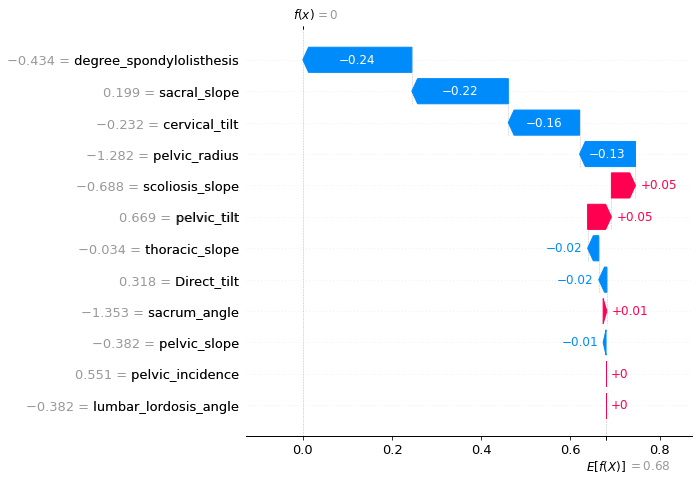

In [25]:
shap.plots.waterfall(shap_values[1, :, 1], max_display=12)

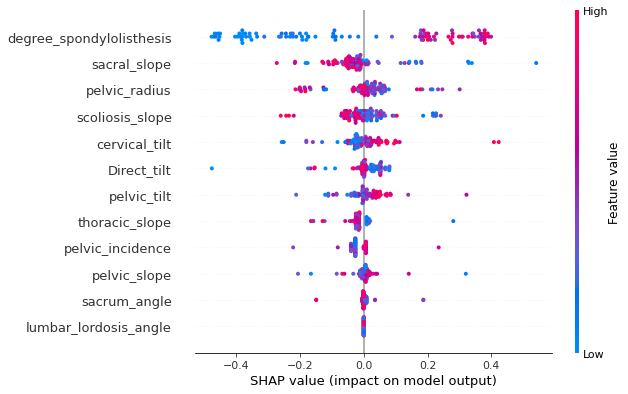

In [26]:
shap.plots.beeswarm(shap_values[:, :, 1], max_display=12)

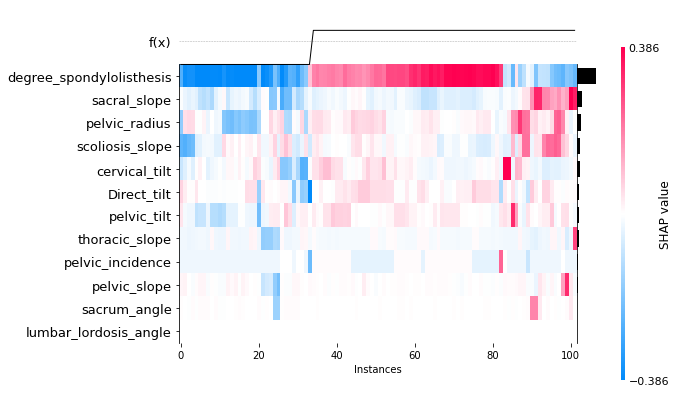

In [27]:
shap.plots.heatmap(shap_values[:, :, 1], max_display=12)

In [28]:
lime = LimeTabular(predict_fn=dt.predict_proba, data=X_train, random_state=404)
lime_local = lime.explain_local(X_test[:10], y_test[:10])
show(lime_local)

<!-- http://127.0.0.1:7001/140230750594960/ -->

In [29]:
edt = ClassificationTree()
edt.fit(X_train, y_train)
edt_local = edt.explain_local(X_test[:10], y_test[:10])
show(edt_local)

<!-- http://127.0.0.1:7001/140230752650896/ -->

In [36]:
edt_global = edt.explain_global()
show(edt_global)

<!-- http://127.0.0.1:7001/140230788314128/ -->

## Random Forest

Random Forest is simply collection is decision trees. This is done by creating shuffled datasets from the original data (bootstrapping with maybe subset of the features) and train a decision tree on each one of the datasets. This way, we reduce the variance in decsion trees performance. The majority voting or combing results from multple decision trees which is called aggregation. 

In [149]:
# build random forest classsifier
rf = RandomForestClassifier(n_estimators=100, random_state=10)

# Grid Search for random forest
parameteres = {'max_depth': np.arange(1,11,1),
               'criterion': ['gini', 'entropy'],
               'n_estimators':np.arange(100, 500, 50)}
grid_rf = GridSearchCV(rf, param_grid=parameteres, cv=StratifiedKFold(n_splits=5), iid = 'True')
grid_rf.fit(X_train, y_train)
print(grid_rf.best_score_)
print(grid_rf.best_params_)

0.821256038647343
{'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 250}


In [150]:
rf = RandomForestClassifier(**grid_rf.best_params_)
rf.fit(X_train, y_train)
y_hat = rf.predict(X_test)
print('Accuracy: ', rf.score(X_test, y_test))
print('Macro F1 Score: ', f1_score(y_test,y_hat, average='macro'))
print('Macro Precision Score: ', precision_score(y_test,y_hat, average='macro'))
print('Macro Recall Score: ', recall_score(y_test,y_hat, average='macro'))

Accuracy:  0.8823529411764706
Macro F1 Score:  0.8633928571428572
Macro Precision Score:  0.8700590640617901
Macro Recall Score:  0.8577075098814229


In [151]:
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.84      0.79      0.81        33
           1       0.90      0.93      0.91        69

    accuracy                           0.88       102
   macro avg       0.87      0.86      0.86       102
weighted avg       0.88      0.88      0.88       102



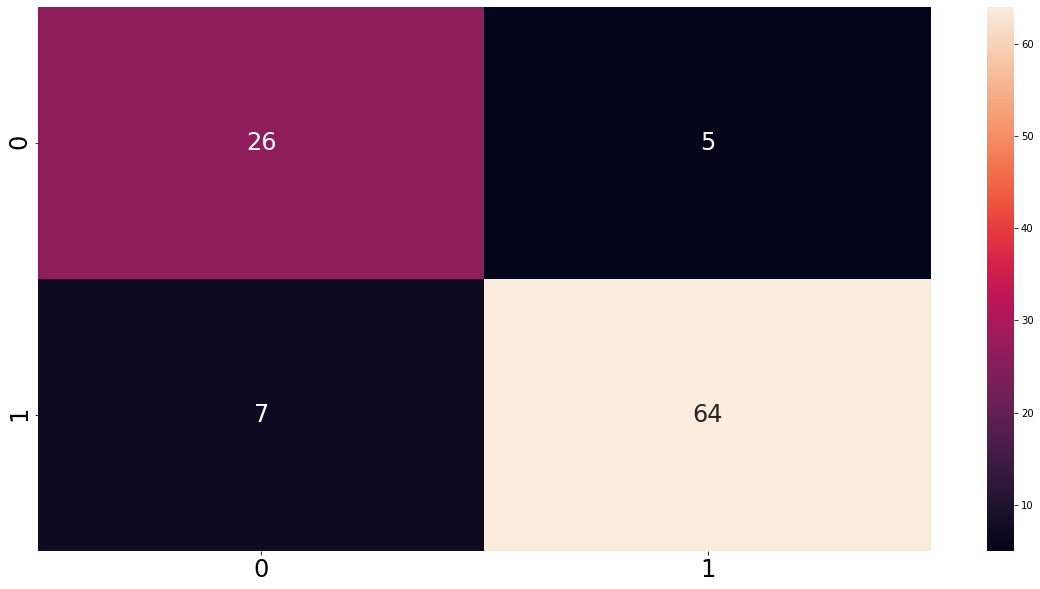

In [152]:
conf_plot(y_hat, y_test)

In [153]:
explainer = shap.TreeExplainer(rf, X_train)
shap_values = explainer(X_test)

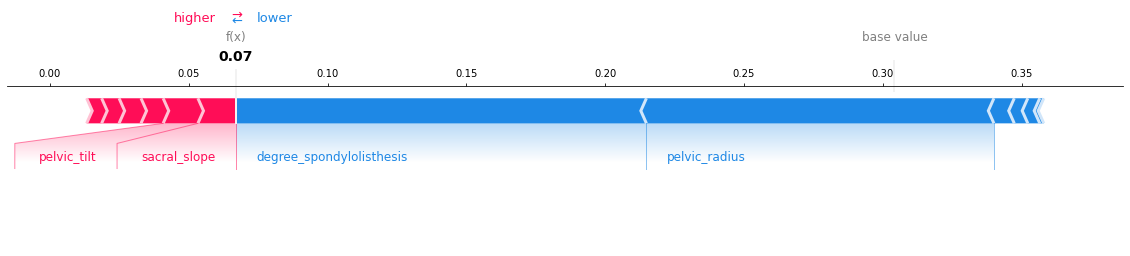

In [154]:
shap.force_plot(shap_values[0, :].base_values[0], shap_values[0, :].values[:, 0], feature_names=column_names[:-1], matplotlib=True)

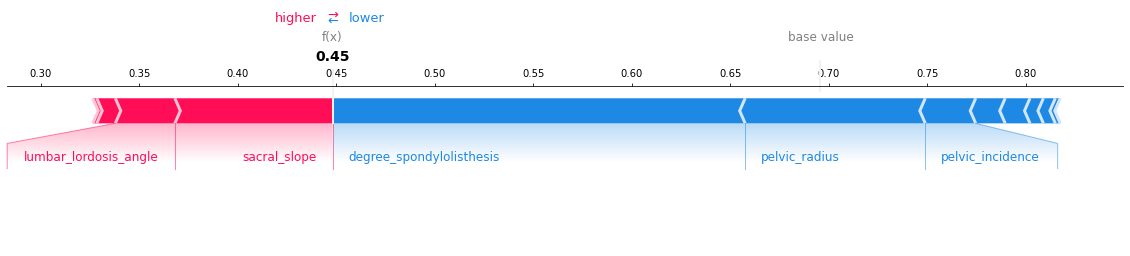

In [164]:
shap.force_plot(shap_values[19, :].base_values[1], shap_values[19, :].values[:, 1], feature_names=column_names[:-1], matplotlib=True)

The next force plot show the explanation of a misclassification

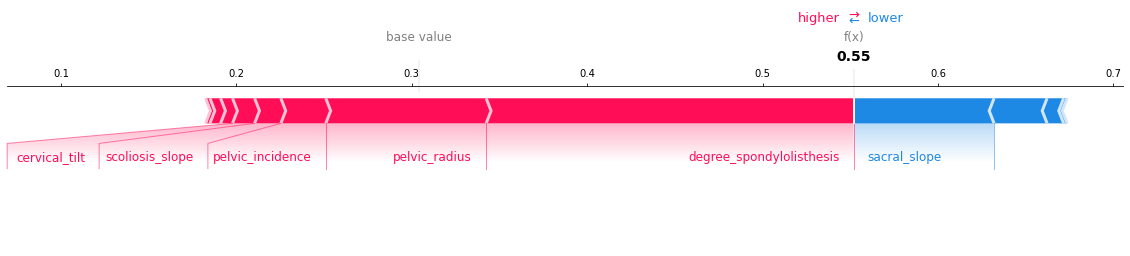

In [165]:
shap.force_plot(shap_values[19, :].base_values[0], shap_values[19, :].values[:, 0], feature_names=column_names[:-1], matplotlib=True)

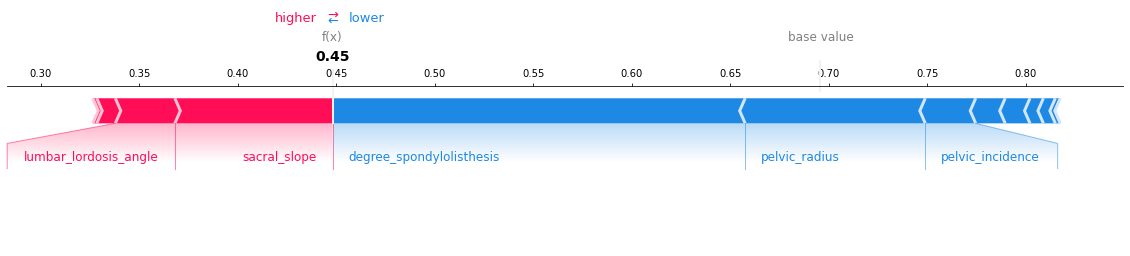

In [166]:
shap.force_plot(shap_values[19, :].base_values[1], shap_values[19, :].values[:, 1], feature_names=column_names[:-1], matplotlib=True)

By looking at this data point, we notice that low degree_spondylolisthesis and high pelvic_radius which trick the model to misclassify this into normal

In [172]:
df.loc[[19]]

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,labels
19,41.729963,12.254074,30.122586,29.475889,116.585706,-1.244402,0.468526,28.5598,12.4637,14.1961,-20.392538,33.0265,1


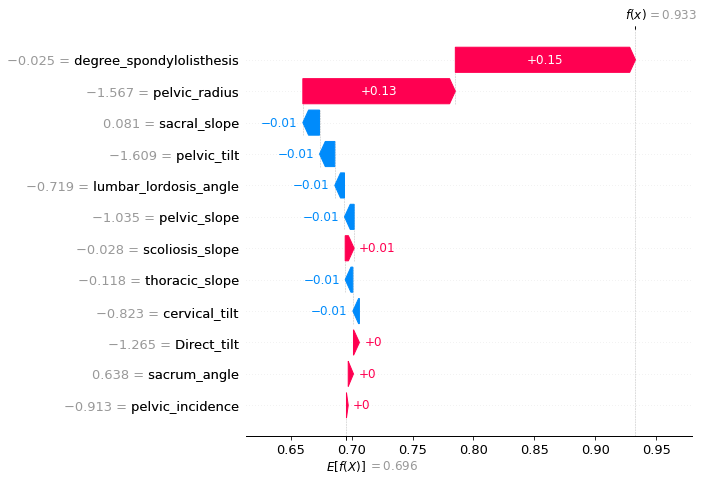

In [156]:
shap.plots.waterfall(shap_values[0, :, 1], max_display=12)

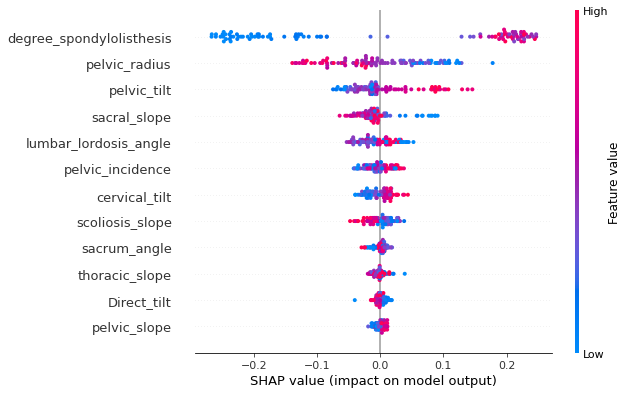

In [157]:
shap.plots.beeswarm(shap_values[:, :, 1], max_display=12)

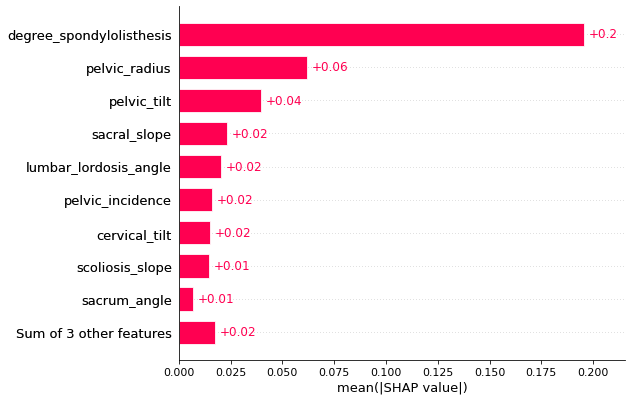

In [158]:
shap.plots.bar(shap_values[:, :, 1].abs.mean(0))

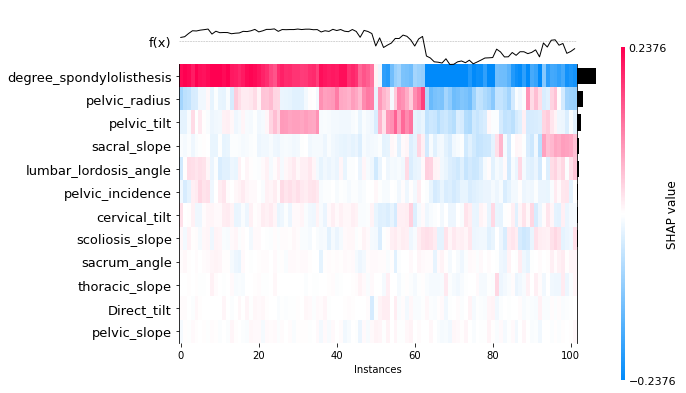

In [159]:
shap.plots.heatmap(shap_values[:, :, 1], max_display=12)

In [160]:
lime = LimeTabular(predict_fn=rf.predict_proba, data=X_train, random_state=404)
lime_local = lime.explain_local(X_test, y_test)
show(lime_local)

<!-- http://127.0.0.1:7001/140229648636112/ -->

## XGBoost classifier

In [135]:
xg = xgb.XGBClassifier(n_estimators=5, seed=404)
xg.fit(X_train, y_train)
y_hat = xg.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_hat))
print('Macro F1 Score: ', f1_score(y_test,y_hat, average='macro'))
print('Macro Precision Score: ', precision_score(y_test,y_hat, average='macro'))
print('Macro Recall Score: ', recall_score(y_test,y_hat, average='macro'))

Accuracy:  0.8627450980392157
Macro F1 Score:  0.8455882352941178
Macro Precision Score:  0.8409381663113007
Macro Recall Score:  0.8511198945981555


## Support Vector Machine

In [44]:
svm = SVC(gamma='auto')

# Grid Search for random forest
parameteres = {'gamma': ['scale', 'auto'],
               'C': np.arange(1, 10, 1),
               'degree': np.arange(1, 5, 1),
               'kernel':['linear', 'poly', 'rbf', 'sigmoid']}
grid_svm = GridSearchCV(svm, param_grid=parameteres, cv=StratifiedKFold(n_splits=5), iid = 'True')
grid_svm.fit(X_train, y_train)
print(grid_svm.best_score_)
print(grid_svm.best_params_)

0.8502415458937198
{'C': 4, 'degree': 1, 'gamma': 'scale', 'kernel': 'poly'}


In [45]:
svm = SVC(**grid_svm.best_params_)
svm.fit(X_train, y_train)
y_hat = svm.predict(X_test)
print('Accuracy: ', svm.score(X_test, y_test))
print('Macro F1 Score: ', f1_score(y_test,y_hat, average='macro'))
print('Macro Precision Score: ', precision_score(y_test,y_hat, average='macro'))
print('Macro Recall Score: ', recall_score(y_test,y_hat, average='macro'))

Accuracy:  0.8627450980392157
Macro F1 Score:  0.840625
Macro Precision Score:  0.8468877782825988
Macro Recall Score:  0.8353096179183135


In [46]:
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.81      0.76      0.78        33
           1       0.89      0.91      0.90        69

    accuracy                           0.86       102
   macro avg       0.85      0.84      0.84       102
weighted avg       0.86      0.86      0.86       102



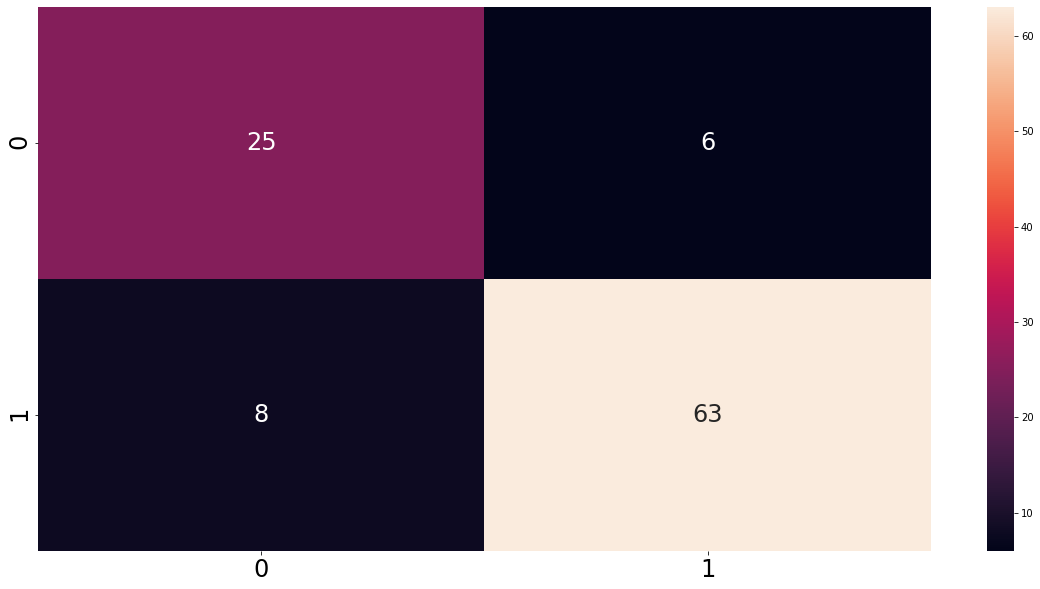

In [47]:
conf_plot(y_hat, y_test)

## Neural Networks

Here, we build a 2 layers artifical neural network. We use linear activations here, we noticed using non-linear activations such as ReLU leads to lower performances..

In [48]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Sequential(
            nn.Linear(12, 128),
            nn.Linear(128, 128),
            nn.Linear(128, 1) 
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear(x)
        return logits

In [49]:
y_test= np.array(y_test)
y_train= np.array(y_train)
X_test = np.array(X_test)
X_train = np.array(X_train)
batch_size=32
xtest = torch.Tensor(X_test).to(device)
ytest = torch.Tensor(y_test).to(device)
test_data = torch.utils.data.TensorDataset(xtest, ytest)
test_iter = torch.utils.data.DataLoader(test_data, batch_size)

Here, we build KFolds for the train data, we want to have a different dataset for validating the model in each fold in order to fine tune hyperparameters and number of epochs.

In [51]:
def build_kfold_dataloader(Xtrain, ytrain, xval, yval):
    
    batch_size=32
    
    xtrain = torch.Tensor(Xtrain).to(device)
    ytrain = torch.Tensor(ytrain).to(device)
    xval = torch.Tensor(xval).to(device)
    yval = torch.Tensor(yval).to(device)   
    train_data = torch.utils.data.TensorDataset(xtrain, ytrain)
    val_data = torch.utils.data.TensorDataset(xval, yval)    
    train_iter = torch.utils.data.DataLoader(train_data, batch_size)
    val_iter = torch.utils.data.DataLoader(val_data, batch_size)
    
    return train_iter, val_iter 

In [52]:
def evaluate(data_iter):
    model.eval()
    preds = []
    trues = []
    running_loss = 0.0
    for i, data in enumerate(data_iter, 0):
        #inputs, labels = data
        
        inputs, labels = data
        outputs = model(inputs)
        labels = labels.float()
        outputs = outputs.squeeze()
        labels = labels.squeeze()
        loss = BCE(outputs, labels)
        outputs = outputs.cpu().detach().numpy().reshape(-1)
        true = labels.cpu().detach().numpy().reshape(-1)
        outputs = list(outputs)
        true = list(true)
        outputs = [1 if i>=0.5 else 0 for i in outputs]
        true = [1 if i>=0.5 else 0 for i in true]
        preds.extend(outputs)
        trues.extend(true)
        running_loss += loss.item()
    return f1_score(preds, trues), running_loss

In [53]:
kf = KFold(n_splits=5)
kf.get_n_splits(X_train)

X_train = np.array(X_train)
y_train = np.array(y_train)

train_f1_values = []
val_f1_values = []
for train_index, val_index in kf.split(X_train):
    Xtrain, Xval = X_train[train_index], X_train[val_index]
    ytrain, yval = y_train[train_index], y_train[val_index]
    train_iter, val_iter  = build_kfold_dataloader(Xtrain, ytrain, Xval, yval)
    model = NeuralNetwork().to(device)    
    BCE = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    
    model.train()
    
    train_f1 = []
    val_f1 = []
    for epoch in range(100):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(train_iter, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = labels.float()
            outputs = outputs.squeeze()
            labels = labels.squeeze()
            loss = BCE(outputs, labels)
            loss.backward()
            optimizer.step()
        running_loss += loss.item()
     
        train_f1.append(evaluate(train_iter)[0])
        val_f1.append(evaluate(val_iter)[0])
        if epoch%10 == 0:
            print('Epoch: ', epoch+1)
            print('Train Loss: ', running_loss, ', Val Loss: ', evaluate(val_iter)[1])
            print('Train Accuracy: ', evaluate(train_iter)[0], ', Val Accuracy: ', evaluate(val_iter)[0])
            
    train_f1_values.append(train_f1)
    val_f1_values.append(val_f1)
    
clear_output()

The following function is used to make plot for the training and validation curves for the 5 folds across the epochs

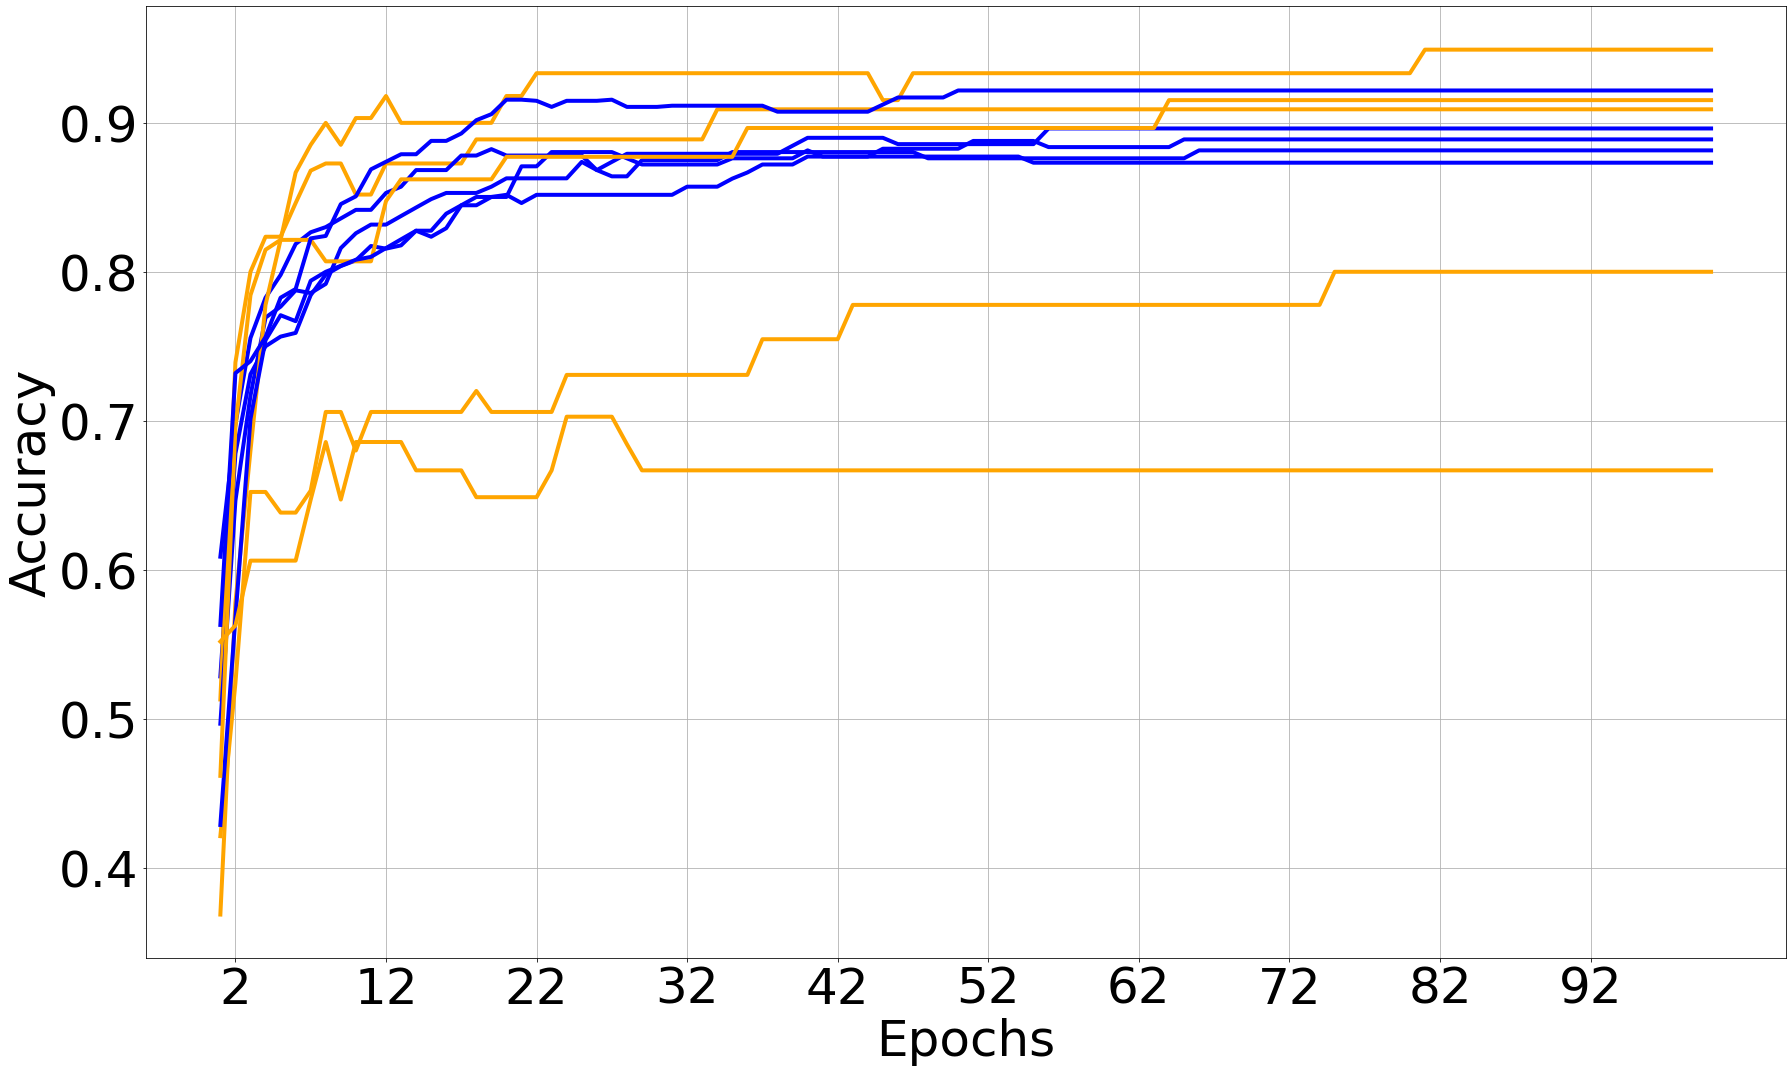

In [54]:
val_f1_values = np.array(val_f1_values)
train_f1_values = np.array(train_f1_values)

def make_plot():
    epochs = range(1, 101)
    xint = range(min(epochs)+1, math.ceil(max(epochs))+1, 10)

    colors = ["#0000FF", "#FFA500"]
    plt.figure(figsize=(25,15))
    for i in range(len(val_f1_values)):
        plt.plot(epochs, train_f1_values[i], linewidth=4, c="#0000FF")
        plt.plot(epochs, val_f1_values[i], linewidth=4, c="#FFA500")
    plt.xlabel('Epochs', fontsize=50)
    plt.ylabel('Accuracy', fontsize=50)
    #plt.legend(fontsize=50)
    plt.xticks(xint, fontsize=50)
    plt.yticks(fontsize=50)
    plt.grid()
    plt.tight_layout()
    plt.show()

make_plot()

We train the model on the entire train data then with 40 epochs where we notice stablization in train and validation accuracy after 40 epochs

In [55]:
X_train = torch.Tensor(X_train).to(device)
y_train = torch.Tensor(y_train).to(device)
train_data = torch.utils.data.TensorDataset(X_train, y_train)
train_iter = torch.utils.data.DataLoader(train_data, batch_size)
    
final_model = NeuralNetwork().to(device)    
BCE = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(final_model.parameters(), lr=0.05)
    
model.train()
    
train_f1 = []
val_f1 = []
for epoch in range(40):
    running_loss = 0.0
    for i, data in enumerate(train_iter, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = final_model(inputs)
        outputs = outputs.squeeze()
        labels = labels.float()
        outputs = outputs.squeeze()
        labels = labels.squeeze()
        loss = BCE(outputs, labels)
        loss.backward()
        optimizer.step()
    running_loss += loss.item()

Now we evaluate the trained artificial neural network on the test data

In [56]:
final_model.eval()

preds = []
for i, data in enumerate(test_iter, 0):
    inputs, labels = data
    y_hat = final_model(inputs)
    y_hat = y_hat.cpu().detach().numpy().reshape(-1)
    y_hat = list(y_hat)
    preds.extend(y_hat)
    #print(y_hat)
preds = np.array(preds).flatten()
y_hat = [1 if i>=0.5 else 0 for i in preds]
y_hat = np.array(y_hat)

print('Accuracy: ', accuracy_score(y_test, y_hat))
print('Macro F1 Score: ', f1_score(y_test,y_hat, average='macro'))
print('Macro Precision Score: ', precision_score(y_test,y_hat, average='macro'))
print('Macro Recall Score: ', recall_score(y_test,y_hat, average='macro'))

Accuracy:  0.8823529411764706
Macro F1 Score:  0.8656126482213439
Macro Precision Score:  0.8656126482213439
Macro Recall Score:  0.8656126482213439


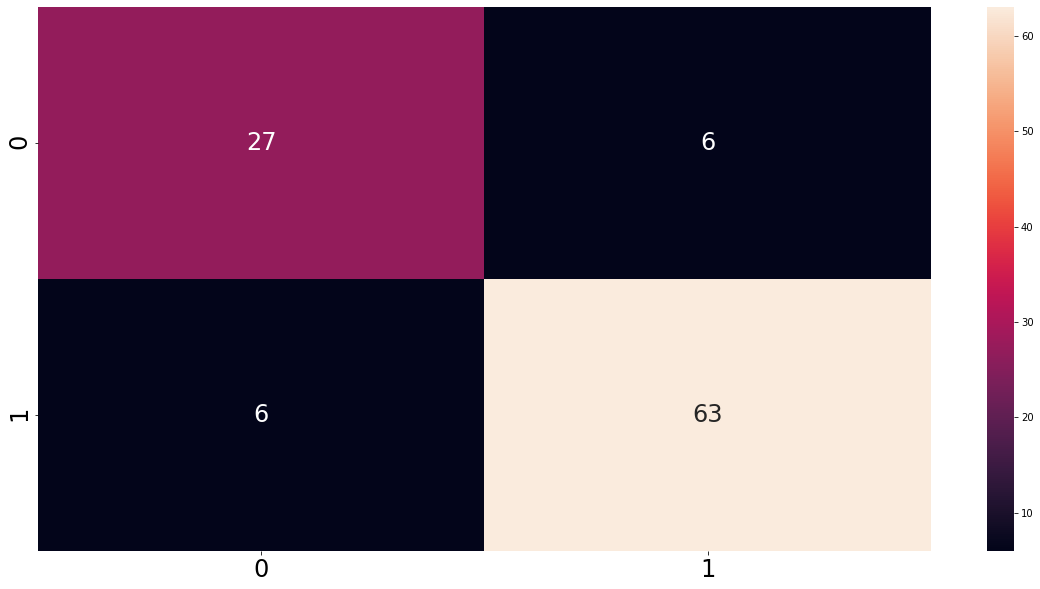

In [57]:
conf_plot(y_hat, y_test)

## 5.Conclusions

- We notice the decision tree achieved relatively lower accuracies compared to the rest of the model. However, This changes when we use random forest because it combined several decision trees that reduce the variance in performances. Random Forest achieved the highest evaluation matrics, followed by multilayer perceptron. Multilayer Percentron does not achived superior accuracies here as it tends to overfit the data. Given that the dataset is relatively small, using neural networks leads to overfit. 

- We noticed using Shapley values that degree_spondyloisthesis, sacral_slope, cervical_tilt are the most significant variables for making predictions. Having higher degree_spondyloisthesis and lower sacral_slope means 'abnormal' prediction.

## 6.References

-  Md. Raihan-Al-Masud ,M. Rubaiyat Hossain Mondal, 2020, Data-driven diagnosis of spinal abnormalities using feature selection and machine learning algorithms.

- https://www.kaggle.com/datasets/sammy123/lower-back-pain-symptoms-dataset